# Import all the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline
import seaborn as sns

from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, f1_score, confusion_matrix
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV


# Below is how evaluate metric NDCG (Normalized Discounted Cumulative Gain) is calculated:

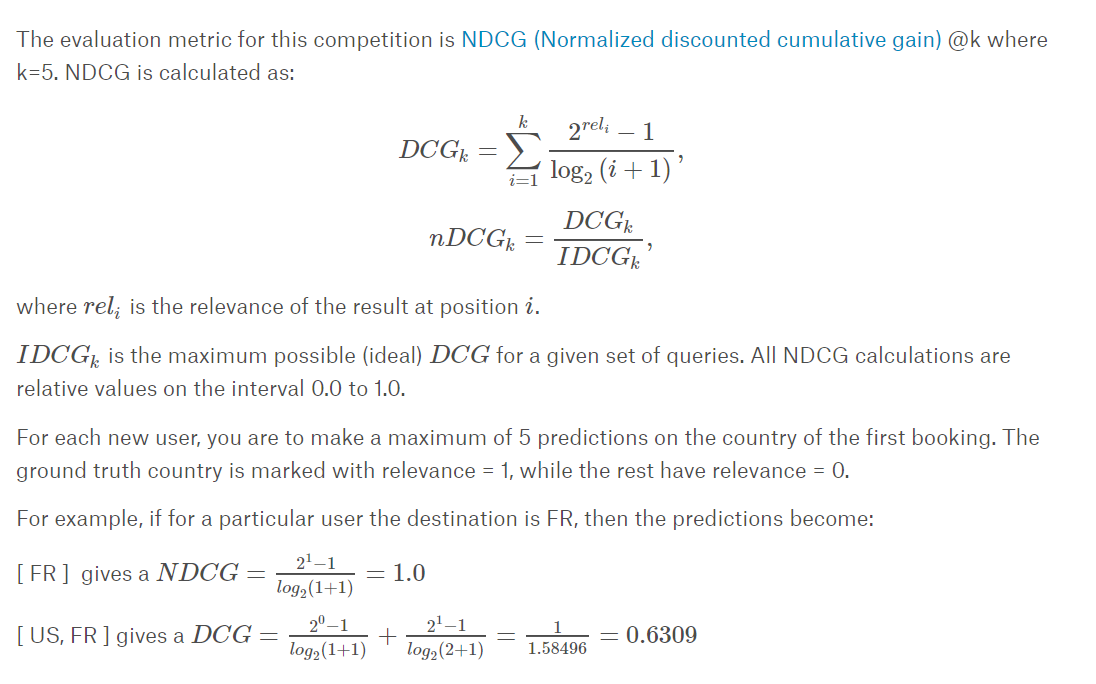

# Define a function which takes in classification model and the training features and output the top five destination countries by user id based on the probability of the classes:

In [2]:
def multinary_classification_model_predict_probability_by_class(multinary_classification_model, training_data_features):
    
    ordered_label=multinary_classification_model.classes_
    #Create a dictionary of label classes:
    
    
    i=0
    label_order_dict=dict()
    
    for label in ordered_label:
        label_order_dict[i]=label
        i=i+1
    
    #Create a dataframe for classification probability
    
    df_prob=pd.DataFrame()
    #Create a dataframe to include thte probability of each class by user id
    for probability_order in range(0,ordered_label.shape[0]):
        df_prob[label_order_dict[probability_order]]=list(zip(*multinary_classification_model.predict_proba(training_data_features)))[probability_order]
    
    #Use the training data features index (user id) as the index for the classification probability data frame
    
    df_prob.set_index(training_data_features.index, inplace=True) 
    
    df_prob=df_prob.reset_index()
    
    df_prob=df_prob.rename(columns={'index':'id'})
    
    
    df_prob_melt=pd.melt(df_prob, id_vars='id',value_vars=['AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NDF', 'NL', 'PT', 'US','other'])

    df_prob_melt=df_prob_melt.rename(columns={'value': 'Probability'})

    df_prob_melt.sort_values(by=['id', 'Probability'], ascending=[True, False], inplace=True)
    


    df_prob_melt_top5_countries=df_prob_melt.groupby('id').head(5)

    return df_prob_melt_top5_countries

# Define the function to return prediction label for the multi class classification model:

In [3]:
def multinary_classification_model_predict_class(multinary_classification_model, training_data_features):
    ordered_label=multinary_classification_model.classes_
    
    multinary_classification_prediction_label=multinary_classification_model.predict(training_data_features)
    
    multinary_classification_prediction_label_df=pd.DataFrame(multinary_classification_prediction_label)
    multinary_classification_prediction_label_df.set_index(training_data_features.index, inplace=True)
    
    multinary_classification_prediction_label_df=multinary_classification_prediction_label_df.rename(columns={0:'label'})
    
    return multinary_classification_prediction_label_df
    
    
    

# Define a function to output the NDCG score based on the model, feature dataset and label dataset:

In [4]:
def funct_NDCG_score_output(logistic_classification_model_input, training_data_features, training_data_labels):
    
    #Create NDCG function here for computing the NDCG Score:
    def func_NDCG(ranking_number):
        if ranking_number<=5:
            score=(2**1-1)/np.log2(ranking_number+1)
        else:
            score=0
        return score
    
    # Output the classification probability for the top 5 destination countries per user:
    
    ordered_label=logistic_classification_model_input.classes_
    #Create a dictionary of label classes:

    i=0
    label_order_dict=dict()

    for label in ordered_label:
        label_order_dict[i]=label
        i=i+1

    #Create a dataframe for classification probability

    df_prob=pd.DataFrame()

    for probability_order in range(0,ordered_label.shape[0]):
        df_prob[label_order_dict[probability_order]]=list(zip(*logistic_classification_model_input.predict_proba(training_data_features)))[probability_order]

    df_prob.set_index(training_data_features.index, inplace=True) 

    df_prob=df_prob.rename(columns={'index':'id'})

    df_prob=df_prob.reset_index()

    df_prob_melt=pd.melt(df_prob, id_vars='id',value_vars=['AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NDF', 'NL', 'PT', 'US','other'])

    df_prob_melt=df_prob_melt.rename(columns={'value': 'Probability'})

    df_prob_melt.sort_values(by=['id', 'Probability'], ascending=[True, False], inplace=True)



    df_prob_melt_top5_countries=df_prob_melt.groupby('id').head(5)

    # Output the classification model prediction class
    
    
    ordered_label1=logistic_classification_model_input.classes_
    
    multinary_classification_prediction_label=logistic_classification_model_input.predict(training_data_features)
    
    multinary_classification_prediction_label_df=pd.DataFrame(multinary_classification_prediction_label)
    multinary_classification_prediction_label_df.set_index(training_data_features.index, inplace=True)
    
    multinary_classification_prediction_label_df=multinary_classification_prediction_label_df.rename(columns={0:'label'})
    
    
    # Merge the country prediction rank along with the actual label into the final data frame for computing the NDCG score based on the country ranking:
    
    Multinary_Logistic_Regression_prediction_probability_df_rank_by_probability=df_prob_melt_top5_countries.groupby('id')['Probability'].rank(ascending=False)
    
    Multinary_Logistic_Regression_prediction_probability_df_rank_by_probability_df=pd.DataFrame(Multinary_Logistic_Regression_prediction_probability_df_rank_by_probability)
    
    Multinary_Logistic_Regression_prediction_probability_df_rank_by_probability_df.rename(columns={'Probability': 'Rank'}, inplace=True)
    
    Multinary_Logistic_Regression_prediction_probability_df_with_ranking=pd.merge(df_prob_melt_top5_countries, Multinary_Logistic_Regression_prediction_probability_df_rank_by_probability_df, left_index=True, right_index=True)
    
    Multinary_Logistic_Regression_prediction_probability_df_with_ranking=Multinary_Logistic_Regression_prediction_probability_df_with_ranking.rename(columns={'variable':'country'})
    
    Multinary_Logistic_Regression_prediction_actual_label_df1=training_data_labels.reset_index()
    
    Multinary_Logistic_Regression_prediction_actual_label_df1=Multinary_Logistic_Regression_prediction_actual_label_df1.rename(columns={'label':'country'})
    
    Multinary_Logistic_Regression_prediction_actual_label_df1=Multinary_Logistic_Regression_prediction_actual_label_df1.rename(columns={'country_destination':'country'})
    
    Multinary_Logistic_Regression_prediction_evaludation_df=pd.merge(Multinary_Logistic_Regression_prediction_actual_label_df1, Multinary_Logistic_Regression_prediction_probability_df_with_ranking, how='left', right_on=['id', 'country'],left_on=['id', 'country'])
    
    #Compute the score:
    Multinary_Logistic_Regression_prediction_evaludation_df['Score']=Multinary_Logistic_Regression_prediction_evaludation_df['Rank'].apply(func_NDCG)
    
    
    return Multinary_Logistic_Regression_prediction_evaludation_df

# Output a function to return the average NDCG Score:

In [5]:
def func_NDCG_average_score(logistic_classification_model_input, training_data_features, training_data_labels):
    #Create NDCG function here for computing the NDCG Score:
    def func_NDCG(ranking_number):
        if ranking_number<=5:
            score=(2**1-1)/np.log2(ranking_number+1)
        else:
            score=0
        return score
    
    # Output the classification probability for the top 5 destination countries per user:
    
    ordered_label=logistic_classification_model_input.classes_
    #Create a dictionary of label classes:

    i=0
    label_order_dict=dict()

    for label in ordered_label:
        label_order_dict[i]=label
        i=i+1

    #Create a dataframe for classification probability

    df_prob=pd.DataFrame()

    for probability_order in range(0,ordered_label.shape[0]):
        df_prob[label_order_dict[probability_order]]=list(zip(*logistic_classification_model_input.predict_proba(training_data_features)))[probability_order]

    df_prob.set_index(training_data_features.index, inplace=True) 

    df_prob=df_prob.rename(columns={'index':'id'})

    df_prob=df_prob.reset_index()

    df_prob_melt=pd.melt(df_prob, id_vars='id',value_vars=['AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NDF', 'NL', 'PT', 'US','other'])

    df_prob_melt=df_prob_melt.rename(columns={'value': 'Probability'})

    df_prob_melt.sort_values(by=['id', 'Probability'], ascending=[True, False], inplace=True)



    df_prob_melt_top5_countries=df_prob_melt.groupby('id').head(5)

    # Output the classification model prediction class
    
    
    ordered_label1=logistic_classification_model_input.classes_
    
    multinary_classification_prediction_label=logistic_classification_model_input.predict(training_data_features)
    
    multinary_classification_prediction_label_df=pd.DataFrame(multinary_classification_prediction_label)
    multinary_classification_prediction_label_df.set_index(training_data_features.index, inplace=True)
    
    multinary_classification_prediction_label_df=multinary_classification_prediction_label_df.rename(columns={0:'label'})
    
    
    # Merge the country prediction rank along with the actual label into the final data frame for computing the NDCG score based on the country ranking:
    
    Multinary_Logistic_Regression_prediction_probability_df_rank_by_probability=df_prob_melt_top5_countries.groupby('id')['Probability'].rank(ascending=False)
    
    Multinary_Logistic_Regression_prediction_probability_df_rank_by_probability_df=pd.DataFrame(Multinary_Logistic_Regression_prediction_probability_df_rank_by_probability)
    
    Multinary_Logistic_Regression_prediction_probability_df_rank_by_probability_df.rename(columns={'Probability': 'Rank'}, inplace=True)
    
    Multinary_Logistic_Regression_prediction_probability_df_with_ranking=pd.merge(df_prob_melt_top5_countries, Multinary_Logistic_Regression_prediction_probability_df_rank_by_probability_df, left_index=True, right_index=True)
    
    Multinary_Logistic_Regression_prediction_probability_df_with_ranking=Multinary_Logistic_Regression_prediction_probability_df_with_ranking.rename(columns={'variable':'country'})
    
    Multinary_Logistic_Regression_prediction_actual_label_df1=training_data_labels.reset_index()
    
    Multinary_Logistic_Regression_prediction_actual_label_df1=Multinary_Logistic_Regression_prediction_actual_label_df1.rename(columns={'label':'country'})
    
    Multinary_Logistic_Regression_prediction_actual_label_df1=Multinary_Logistic_Regression_prediction_actual_label_df1.rename(columns={'country_destination':'country'})
    
    Multinary_Logistic_Regression_prediction_evaludation_df=pd.merge(Multinary_Logistic_Regression_prediction_actual_label_df1, Multinary_Logistic_Regression_prediction_probability_df_with_ranking, how='left', right_on=['id', 'country'],left_on=['id', 'country'])
    
    #Compute the score:
    Multinary_Logistic_Regression_prediction_evaludation_df['Score']=Multinary_Logistic_Regression_prediction_evaludation_df['Rank'].apply(func_NDCG)
    
    
    return Multinary_Logistic_Regression_prediction_evaludation_df['Score'].mean()

# Loading the Airbnb dataset below:

- Check confusion matrix 
- see the distribution/spread for the NDCG score for the model


You can download the user_training_dataset_update.csv from the link below:

https://drive.google.com/open?id=1tQGlNvkmGVPGcmQID2NNd5p8bkLBxofM

In [6]:
user_training_dataset_update=pd.read_csv("C:/Users/yuka.abe/Desktop/Airbnb Kaggle DataSet/user_training_dataset_update.csv")

user_training_dataset_update_multinary_classfication=user_training_dataset_update.copy()
user_training_dataset_update_multinary_classfication.loc[user_training_dataset_update_multinary_classfication['first_browser']=='-unknown-', 'first_browser']='Unknown'
user_training_dataset_update_multinary_classfication.loc[user_training_dataset_update_multinary_classfication['gender']=='-unknown-', 'gender']='Unknown'



In [7]:
del user_training_dataset_update_multinary_classfication['trip_booking_flag']                                          

In the user_training_dataset_update_multinary_classfication dataset, the following fields have some missing values:
- first_affiliate_tracked 
- age_computed
- Total time spent (in seconds) 
- Account_creation_before_booking_flag 
- session count  

In [8]:
user_training_dataset_update_multinary_classfication.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Columns: 390 entries, id to session count_bucket
dtypes: float64(365), int64(9), object(16)
memory usage: 635.1+ MB


Input the null value for first_affiliate_tracked field as "unknown", Input the null value for "Account_creation_before_booking_flag" as "unknown"

In [9]:
user_training_dataset_update_multinary_classfication.loc[pd.isnull(user_training_dataset_update_multinary_classfication['first_affiliate_tracked']), 'first_affiliate_tracked']='Unknown'
user_training_dataset_update_multinary_classfication.loc[pd.isnull(user_training_dataset_update_multinary_classfication['Account_creation_before_booking_flag']), 'Account_creation_before_booking_flag']='Unknown'

# Define function to convert all the categorical variables into dummy variables:

In [10]:
def func_get_dummy_variables_for_categorical_variables(dataset, variable_name):
    
    dummy_variables_series=pd.get_dummies(dataset[variable_name])
    dummy_variables_series_df=pd.DataFrame(dummy_variables_series)
    
    for column in dummy_variables_series_df.columns:
        new_column_name=variable_name+'_'+str(column)
        if new_column_name in dataset.columns:
            del dataset[new_column_name]
        
        dummy_variables_series_df=dummy_variables_series_df.rename(columns={column: new_column_name})
        
        
    del dataset[variable_name]
    #del dummy_variables_series_df[dummy_variables_series_df.columns[-1]]
    return dummy_variables_series_df

In [11]:
user_training_dataset_update_multinary_classfication1=user_training_dataset_update_multinary_classfication.copy()

Include all the relevant fields into the dataset used for the multi class model:  user_training_dataset_update_multinary_classfication1

In [12]:
column_to_include_list=['id',
    
# Below are the category variables:
'gender', 
'signup_method',   
'signup_flow',  
'language',  
'affiliate_channel', 
'affiliate_provider',   
'first_affiliate_tracked',   
'signup_app',    
'first_device_type', 
'first_browser',   
'Account_creation_before_booking_flag',  
'Account_creation_date_month',
'Account_creation_date_year',
'Account_creation_date_day', 
'Account_creation_date_day_of_week',  
'first_active_date_month',
'first_active_date_year',
'first_active_date_day',
'first_active_date_dayofweek',
'age_bucket',
'session count_bucket',  
'Total time spent (in seconds)_bucket',                                          

#Below are the continuous variables:
'Total time spent (in seconds)_fill_null_zero',   
'session count_fill_null_zero', 
    
#Below's the label variable:
'country_destination' ]

session_count_type_column_list=[c for c in user_training_dataset_update_multinary_classfication1.columns if 'Session Count by' in c  ]

In [13]:
for c in session_count_type_column_list:
    column_to_include_list.append(c)

In [14]:
user_training_dataset_update_multinary_classfication1=user_training_dataset_update_multinary_classfication1[column_to_include_list]

In [15]:
user_training_dataset_update_multinary_classfication1=user_training_dataset_update_multinary_classfication1.set_index('id')

All the data in the user_training_dataset_update_multinary_classfication1 dataset does not have missing values:

In [16]:
for column in user_training_dataset_update_multinary_classfication1.columns:
    row_count=user_training_dataset_update_multinary_classfication1[column].count()
    if row_count<user_training_dataset_update_multinary_classfication1.shape[0]:
        print(column)
    

In [17]:
user_training_dataset_update_multinary_classfication1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 213451 entries, gxn3p5htnn to nw9fwlyb5f
Columns: 384 entries, gender to Session Count by action name_zendesk_login_jwt
dtypes: float64(361), int64(9), object(14)
memory usage: 627.0+ MB


Encode the category variables into dummy variables:

List out all the categorical variables name into the Categorical_variable_list:

In [18]:
Categorical_variable_list=['gender', 
'signup_method',   
'signup_flow',  
'language',  
'affiliate_channel', 
'affiliate_provider',   
'first_affiliate_tracked',   
'signup_app',    
'first_device_type', 
'first_browser',   
'Account_creation_before_booking_flag',  
'Account_creation_date_month',
'Account_creation_date_year',
'Account_creation_date_day', 
'Account_creation_date_day_of_week',  
'first_active_date_month',
'first_active_date_year',
'first_active_date_day',
'first_active_date_dayofweek',
'age_bucket',
'session count_bucket',  
'Total time spent (in seconds)_bucket']

In [19]:
def func_get_dummy_variables_for_categorical_variables(dataset, variable_name):
    
    dummy_variables_series=pd.get_dummies(dataset[variable_name])
    dummy_variables_series_df=pd.DataFrame(dummy_variables_series)
    
    for column in dummy_variables_series_df.columns:
        new_column_name=variable_name+'_'+str(column)
        if new_column_name in dataset.columns:
            del dataset[new_column_name]
        
        dummy_variables_series_df=dummy_variables_series_df.rename(columns={column: new_column_name})
        
        
    del dataset[variable_name]
    #del dummy_variables_series_df[dummy_variables_series_df.columns[-1]]
    return dummy_variables_series_df

In [20]:
for variable_name in Categorical_variable_list:
    df_dummy=func_get_dummy_variables_for_categorical_variables(user_training_dataset_update_multinary_classfication1, variable_name)
    user_training_dataset_update_multinary_classfication1=user_training_dataset_update_multinary_classfication1.merge(df_dummy, on=None, left_index=True, right_index=True)

Check if there's any null value in the user_training_dataset_update_binary_classfication1 dataset:

In [21]:
for column in user_training_dataset_update_multinary_classfication1.columns:
    row_count=user_training_dataset_update_multinary_classfication1[column].count()
    if row_count<user_training_dataset_update_multinary_classfication1.shape[0]:
        print(column)

There's no column with null value after having preprocessed the data.

Define the feature list:

In [22]:
feature_list1=list(user_training_dataset_update_multinary_classfication1.columns)

In [23]:
feature_list1.remove('Total time spent (in seconds)_fill_null_zero')
feature_list1.remove('session count_fill_null_zero')

In [24]:
feature_list1.remove('country_destination')

In [25]:
feature_list2=list(user_training_dataset_update_multinary_classfication1.columns)

In [26]:
user_training_dataset_update_multinary_classfication1.columns[user_training_dataset_update_multinary_classfication1.columns.str.contains('bucket')]

Index(['age_bucket_(17.999, 26.0]', 'age_bucket_(26.0, 28.0]',
       'age_bucket_(28.0, 31.0]', 'age_bucket_(31.0, 34.0]',
       'age_bucket_(34.0, 37.0]', 'age_bucket_(37.0, 43.0]',
       'age_bucket_(43.0, 53.0]', 'age_bucket_(53.0, 122.0]',
       'age_bucket_Unknown', 'session count_bucket_(0.999, 5.0]',
       'session count_bucket_(10.0, 17.0]',
       'session count_bucket_(111.0, 182.0]',
       'session count_bucket_(17.0, 26.0]',
       'session count_bucket_(182.0, 2644.0]',
       'session count_bucket_(26.0, 38.0]',
       'session count_bucket_(38.0, 53.0]', 'session count_bucket_(5.0, 10.0]',
       'session count_bucket_(53.0, 76.0]',
       'session count_bucket_(76.0, 111.0]', 'session count_bucket_Unknown',
       'Total time spent (in seconds)_bucket_(-0.001, 169857.6]',
       'Total time spent (in seconds)_bucket_(1248857.2, 2444996.4]',
       'Total time spent (in seconds)_bucket_(169857.6, 584557.4]',
       'Total time spent (in seconds)_bucket_(2444996.4, 

In [27]:
feature_to_remove=[i for i in  feature_list2 if 'session count_bucket_' in i]

In [28]:
feature_to_remove2=[i for i in  feature_list2 if 'Total time spent (in seconds)_bucket_' in i]

In [29]:
for i in feature_to_remove:
    feature_list2.remove(i)
    
for i in feature_to_remove2:
    feature_list2.remove(i)
    

Remove the trip_booking_flag variable  (label):

In [30]:
feature_list2.remove('country_destination')       

# Remove the data with "NDF" as the first destination country and focus on making predictions on only the users who have made a booking.

In [31]:
user_training_dataset_update_multinary_classfication1=user_training_dataset_update_multinary_classfication1.loc[user_training_dataset_update_multinary_classfication1['country_destination']!='NDF']

In [32]:
user_training_dataset_update_multinary_classfication1.head()

,Total time spent (in seconds)_fill_null_zero,session count_fill_null_zero,country_destination,Session Count by action name_10,Session Count by action name_11,Session Count by action name_12,Session Count by action name_15,Session Count by action name_about_us,Session Count by action name_accept_decline,Session Count by action name_account,...,"session count_bucket_(5.0, 10.0]","session count_bucket_(53.0, 76.0]","session count_bucket_(76.0, 111.0]",session count_bucket_Unknown,"Total time spent (in seconds)_bucket_(-0.001, 169857.6]","Total time spent (in seconds)_bucket_(1248857.2, 2444996.4]","Total time spent (in seconds)_bucket_(169857.6, 584557.4]","Total time spent (in seconds)_bucket_(2444996.4, 38221363.0]","Total time spent (in seconds)_bucket_(584557.4, 1248857.2]",Total time spent (in seconds)_bucket_Unknown
id,,,,,,,,,,,,,,,,,,,,,
4ft3gnwmtx,0.0,0.0,US,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,1
bjjt8pjhuk,0.0,0.0,other,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,1
87mebub9p4,0.0,0.0,US,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,1
osr2jwljor,0.0,0.0,US,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,1
lsw9q7uk0j,0.0,0.0,US,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,1


In [33]:
user_training_dataset_update_multinary_classfication1['country_destination'].value_counts()/user_training_dataset_update_multinary_classfication1.shape[0]

US       0.701579
other    0.113533
FR       0.056497
IT       0.031887
GB       0.026139
ES       0.025296
CA       0.016062
DE       0.011934
NL       0.008571
AU       0.006062
PT       0.002441
Name: country_destination, dtype: float64

#  Develop multi class classification model. Use Country Destination as the label and rest of the variables as features


# Use Logistic Regression to fit the model: 

Define the label and feature:

In [152]:
y, X =user_training_dataset_update_multinary_classfication1['country_destination'], user_training_dataset_update_multinary_classfication1[feature_list1]

# Split the training dataset and testing set into two parts: 
- Training dataset (80%)
- Testing dataset(20%

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [154]:
print("Shape of traing feature set:", X_train.shape)
print("Shape of testing feature set:", X_test.shape)
print("Shape of training label set:", y_train.shape)
print("Shape of testing label set:", y_test.shape)

Shape of traing feature set: (71126, 648)
Shape of testing feature set: (17782, 648)
Shape of training label set: (71126,)
Shape of testing label set: (17782,)


# Fit Logistic Regression on the oversampled traning dataset:

In [155]:
Multinary_Logistic_Regression=LogisticRegression(multi_class='multinomial', solver='lbfgs')

In [156]:
Multinary_Logistic_Regression.fit(X_train, y_train)

C:\Users\yuka.abe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

# Model Performance on the training set:

In [45]:
print("Accuracy Score: ", cross_val_score(Multinary_Logistic_Regression, X_train,y_train, cv=5).mean())

C:\Users\yuka.abe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\yuka.abe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\yuka.abe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\yuka.abe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Accuracy Score:  0.7014313245370675


C:\Users\yuka.abe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


# Model Performance on the testing set:

In [161]:
print("Accuracy Score: ", accuracy_score(y_test, Multinary_Logistic_Regression.predict(X_test)))

Accuracy Score:  0.6998650320548869


# Error Analysis using confusion matrix:

- In the training dataset, the logistic regression model here classifies most of the users into "US".
- The prediction model is doing very poorly for countries like AU, CA, PT, NT, DE, ES and GB. 
- The model is performing well in predicting the users who want to go to US as their first destination. 
- But the model is also generating errors by misclassifying some of the users who booked other countries into US.

In [71]:
Multinary_Logistic_Regression.classes_

array(['AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NL', 'PT', 'US',
       'other'], dtype=object)

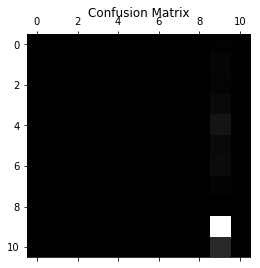

In [74]:
from sklearn.metrics import confusion_matrix
conf_mx=confusion_matrix(y_train, y_train_pred)
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.title("Confusion Matrix")
plt.show()

# Use the confusion matrix to plot on the errors:

Divide each value in the confusion matrix by the number of users in each predicted class.

In [56]:
row_sums=conf_mx.sum(axis=1, keepdims=True)

In [57]:
normed_conf_mx=conf_mx/row_sums

Fill the diagnol with zeros to keep only the errors and plot the results:

In [58]:
np.fill_diagonal(normed_conf_mx,0)

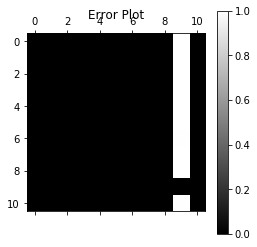

In [75]:
plt.matshow(normed_conf_mx, cmap=plt.cm.gray)
plt.colorbar()
plt.title("Error Plot")
plt.show()


# Leverage the function to evaluate the performance on the testing set:

In [77]:
logistic_regression_evaluation_final_df_test_set=funct_NDCG_score_output(Multinary_Logistic_Regression, X_test, y_test)
logistic_regression_evaluation_final_df_test_set.head()

C:\Users\yuka.abe\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,id,country,Probability,Rank,Score
0,04dxbu0qno,US,0.806833,1.0,1.000000
1,rn0gsgnyy4,GB,0.038652,5.0,0.386853
2,uxo8lkzmss,US,0.637175,1.0,1.000000
3,sw4ribafvr,other,0.151653,2.0,0.630930
4,adddkg968f,US,0.792671,1.0,1.000000


The average score here for the model is 82%.

In [78]:
logistic_regression_evaluation_final_df_test_set.Score.mean()

0.8245312206840067

Here's the distribution of the country predictions:

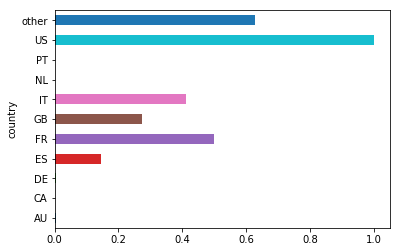

In [79]:
logistic_regression_evaluation_final_df_test_set.groupby('country')['Score'].mean().plot(kind='barh')

Below is the distribution of the score

C:\Users\yuka.abe\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


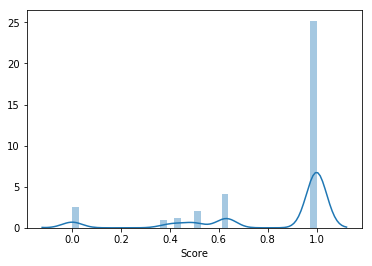

In [81]:
sns.distplot(logistic_regression_evaluation_final_df_test_set.Score)

# Confusion Matrix and Error analysis on testing set:

In [83]:
y_test_pred=Multinary_Logistic_Regression.predict(X_test)

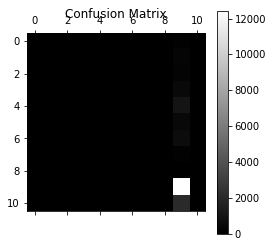

In [91]:
conf_mx_test=confusion_matrix(y_test, y_test_pred)
plt.matshow(conf_mx_test, cmap=plt.cm.gray)
plt.colorbar()
plt.title("Confusion Matrix")
plt.show()

# Use the confusion matrix to plot on the errors:

Same as the training set, many errors are generated by misclassifying other countries into US.

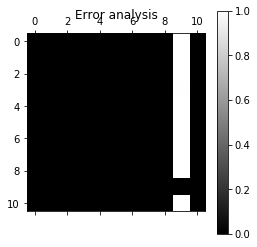

In [89]:
row_sums_test=conf_mx_test.sum(axis=1, keepdims=True)
conf_mx_test_normalized=conf_mx_test/row_sums_test
np.fill_diagonal(conf_mx_test_normalized,0)
plt.matshow(conf_mx_test_normalized, cmap=plt.cm.gray)
plt.colorbar()
plt.title("Error analysis")
plt.show()

# Use Random Forest to train the model: 

In [92]:
y, X =user_training_dataset_update_multinary_classfication1['country_destination'], user_training_dataset_update_multinary_classfication1[feature_list2]

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [94]:
print("Shape of features of training dataset: ", X_train.shape)
print("Shape of features of testing dataset: ", X_test.shape)
print("Shape of labels of training dataset :", y_train.shape)
print("Shape of labels of testing dataset: ", y_test.shape)

Shape of features of training dataset:  (71126, 633)
Shape of features of testing dataset:  (17782, 633)
Shape of labels of training dataset : (71126,)
Shape of labels of testing dataset:  (17782,)


# Try Random Search with Cross Validation to get the best hyper parameter tuning:

In [95]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 150, stop = 500, num = 50)]
# Number of features to consider at every split
#max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               #'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [150,
                  157,
                  164,
                  171,
                  178,
                  185,
                  192,
                  200,
                  207,
                  214,
                  221,
                  228,
                  235,
                  242,
                  250,
                  257,
                  264,
                  271,
                  278,
                  285,
                  292,
                  300,
                  307,
                  314,
                  321,
                  328,
                  335,
                  342,
                  350,
                  357,
                  364,
                  371,
                  378,
                  385,
                  392,
                  400,
         

Use the Randomized Search CV to get the optimal hyperparameter:

In [96]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(random_state = 42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 10,
                              #scoring="roc_auc", 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
rf_random.fit(X_train, y_train);

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 17.2min finished


Get the best parameters from the randomized search:

In [99]:
rf_random.best_params_

{'n_estimators': 442,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_depth': None,
 'bootstrap': True}

Given the best hyperparameter recommeneded by the randomized search, narrow down the range for finalize the final hyperparameters to use for the model.

Create the parameter grid based on the results of the random search:

In [100]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [15, 20,25],
    'bootstrap':[True],
    'n_estimators': [442, 444, 446, 448],
    'min_samples_split': [5],
    'min_samples_leaf':[2]
}

# Create a base model
random_forest_clf = RandomForestClassifier(random_state = 22)

# Instantiate the grid search model
grid_search_random_forest = GridSearchCV(estimator = random_forest_clf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)

In [101]:
# Fit the grid search to the data
grid_search_random_forest.fit(X_train, y_train);

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 17.5min finished


# Below are the best parameters out of the randomized search:

In [102]:
grid_search_random_forest.best_params_


{'bootstrap': True,
 'max_depth': 15,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 442}

In [103]:
best_grid_random_forest = grid_search_random_forest.best_estimator_


In [148]:
best_grid_random_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=442, n_jobs=None,
            oob_score=False, random_state=22, verbose=0, warm_start=False)

# Evaluate the performance of the random forest model

The average accuracy score for cross validation is 70%.

In [149]:
accuracy_score(y_test, best_grid_random_forest.predict(X_test))

0.7001462152738724

# Compute the NDCG Score

In [112]:
random_forest_evaluation_final_df_test_set=funct_NDCG_score_output(best_grid_random_forest, X_test, y_test)
random_forest_evaluation_final_df_test_set.head()

C:\Users\yuka.abe\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,id,country,Probability,Rank,Score
0,8r8hcu9igg,US,0.694921,1.0,1.0
1,evdxqoq3do,US,0.643408,1.0,1.0
2,qdblwanhlv,US,0.698279,1.0,1.0
3,3wba2m45lv,US,0.772260,1.0,1.0
4,1wz3ntyvyj,US,0.674289,1.0,1.0


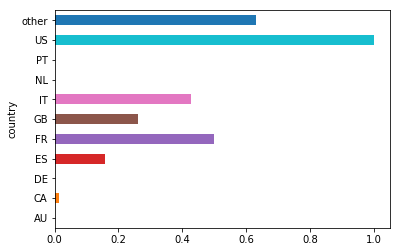

In [113]:
random_forest_evaluation_final_df_test_set.groupby('country')['Score'].mean().plot(kind='barh')

The average score for the finalized random forest classifier here is 83%.

In [114]:
random_forest_evaluation_final_df_test_set['Score'].mean()

0.8250720784561946

Below is the distribution of the score from the random forest model:

C:\Users\yuka.abe\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


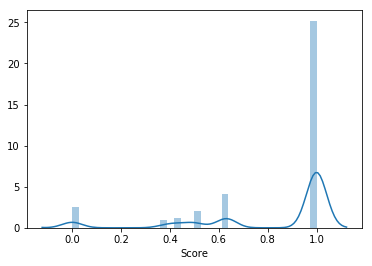

In [115]:
sns.distplot(random_forest_evaluation_final_df_test_set['Score'])

In [116]:
y_test_pred=cross_val_predict(best_grid_random_forest, X_test, y_test, cv=5)

# Plot the confusion matrix:

By looking at the confusion matrix, you will find that since most of the data have "US" as label, the model can only ensure the accuracy in predicting "US" label.

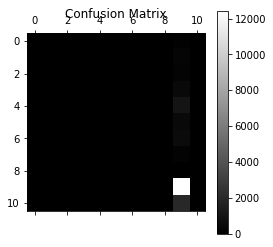

In [117]:
conf_mx_test=confusion_matrix(y_test, y_test_pred)
plt.matshow(conf_mx_test, cmap=plt.cm.gray)
plt.colorbar()
plt.title("Confusion Matrix")
plt.show()

In [122]:
y_test.value_counts()

US       12445
other     2036
FR        1003
IT         569
GB         475
ES         442
CA         267
DE         228
NL         161
AU         110
PT          46
Name: country_destination, dtype: int64

In [123]:
row_sums_test=conf_mx_test.sum(axis=1, keepdims=True)

By looking at the error plot, a lot predictions toward "US" has generated many errors.


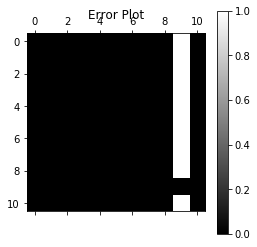

In [120]:
row_sums_test=conf_mx_test.sum(axis=1, keepdims=True)
conf_mx_test_normalized=conf_mx_test/row_sums_test
np.fill_diagonal(conf_mx_test_normalized,0)
plt.matshow(conf_mx_test_normalized, cmap=plt.cm.gray)
plt.colorbar()
plt.title("Error Plot")
plt.show()




<Figure size 720x432 with 0 Axes>

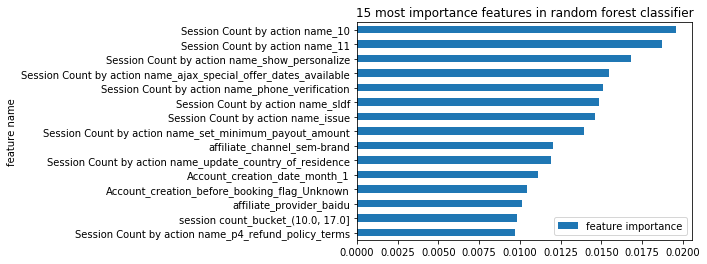

In [121]:
plt.figure(figsize=(10, 6))
model_random_forest_multi_class_feature_importance_df=pd.DataFrame(list(zip(feature_list1, best_grid_random_forest.feature_importances_)), columns=['feature name', 'feature importance'])
model_random_forest_multi_class_feature_importance_df=model_random_forest_multi_class_feature_importance_df.sort_values(by='feature importance', ascending=False)
model_random_forest_multi_class_feature_importance_df.set_index('feature name', inplace=True)
model_random_forest_multi_class_feature_importance_df[:15]. sort_values(by='feature importance', ascending=True).plot(kind='barh', title="15 most importance features in random forest classifier")
plt.show()

# Use XG boost to train the model

In [34]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

In [35]:
y, X =user_training_dataset_update_multinary_classfication1['country_destination'], user_training_dataset_update_multinary_classfication1[feature_list2]

In [36]:
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.2, random_state=23)

In [37]:
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]
X_test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test.columns.values]


In [38]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

In [41]:
model_xgboost = XGBClassifier(max_depth=10,
                           min_child_weight=1,
                           learning_rate=0.1,
                           n_estimators=5,
                           silent=True,
                           objective='multi:softprob',
                           num_class=12,
                           gamma=0,
                           max_delta_step=0,
                           subsample=1,
                           colsample_bytree=1,
                           colsample_bylevel=1,
                           reg_alpha=0,
                           reg_lambda=0,
                           scale_pos_weight=1,
                           seed=1,
                           missing=None)

In [42]:
kfold = StratifiedKFold(n_splits=5, random_state=7)
results = cross_val_score(model_xgboost, X_train, y_train, cv=kfold, scoring='neg_log_loss')

The mean of the negative log loss is -1.32

In [43]:
results.mean()

-1.6781858465544317

In [44]:
model_xgboost.fit(X_train,  y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=5,
       n_jobs=1, nthread=None, num_class=12, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=0, scale_pos_weight=1,
       seed=1, silent=True, subsample=1)

In [45]:
y_predict=model_xgboost.predict(X_test)
y_pro = model_xgboost.predict_proba(X_test)[:, 1]

# Compute the NDCG Score on the prediced countries:

In [46]:
xgboost_evaluation_final_df_test_set=funct_NDCG_score_output(model_xgboost, X_test, y_test)
xgboost_evaluation_final_df_test_set.head()

C:\Users\yuka.abe\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,id,country,Probability,Rank,Score
0,i592c1ahbz,US,0.262211,1.0,1.0
1,pv7hr0rano,US,0.251454,1.0,1.0
2,fcnrcsdin6,ES,NaN,NaN,0.0
3,8sed9t9js2,US,0.258078,1.0,1.0
4,vkqoivqq9f,US,0.250764,1.0,1.0


The average NDGC score is 0.82 and the accuracy score on the testing set is 0.70.

In [47]:
xgboost_evaluation_final_df_test_set.Score.mean()

0.8231714239341013

In [48]:
xgboost_evaluation_final_df_test_set.head()

,id,country,Probability,Rank,Score
0,i592c1ahbz,US,0.262211,1.0,1.0
1,pv7hr0rano,US,0.251454,1.0,1.0
2,fcnrcsdin6,ES,NaN,NaN,0.0
3,8sed9t9js2,US,0.258078,1.0,1.0
4,vkqoivqq9f,US,0.250764,1.0,1.0


# Average score by destination countries:

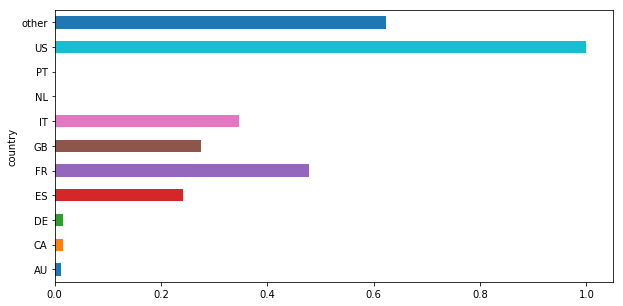

In [49]:
plt.rcParams['figure.figsize']=[10,5]
xgboost_evaluation_final_df_test_set.groupby('country')['Score'].mean().plot(kind='barh')

# Distrbution of the score:

C:\Users\yuka.abe\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


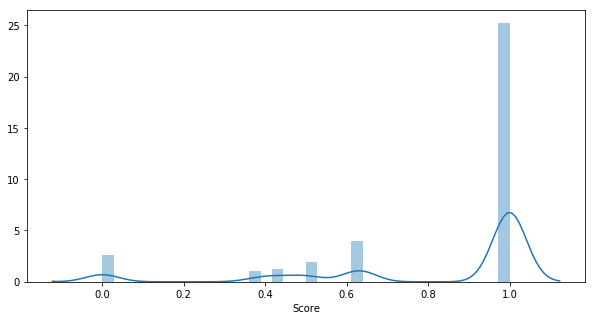

In [50]:
sns.distplot(xgboost_evaluation_final_df_test_set['Score'])

# Accuracy score on the testing dataset:

In [51]:
accuracy_score(y_test, model_xgboost.predict(X_test))

0.7005961084242492

# Confusion Matrix:

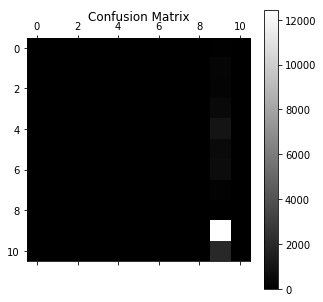

In [52]:
conf_xgb_test=confusion_matrix(y_test, model_xgboost.predict(X_test))
plt.matshow(conf_xgb_test, cmap=plt.cm.gray)
plt.title("Confusion Matrix")
plt.colorbar()
plt.show()

# Below are the important features based on the xgboost model:

In [59]:
X_train.columns[X_train.columns.str.contains('flag')]

Index(['Account_creation_before_booking_flag_0.0',
       'Account_creation_before_booking_flag_1.0',
       'Account_creation_before_booking_flag_2.0',
       'Account_creation_before_booking_flag_Unknown'],
      dtype='object')

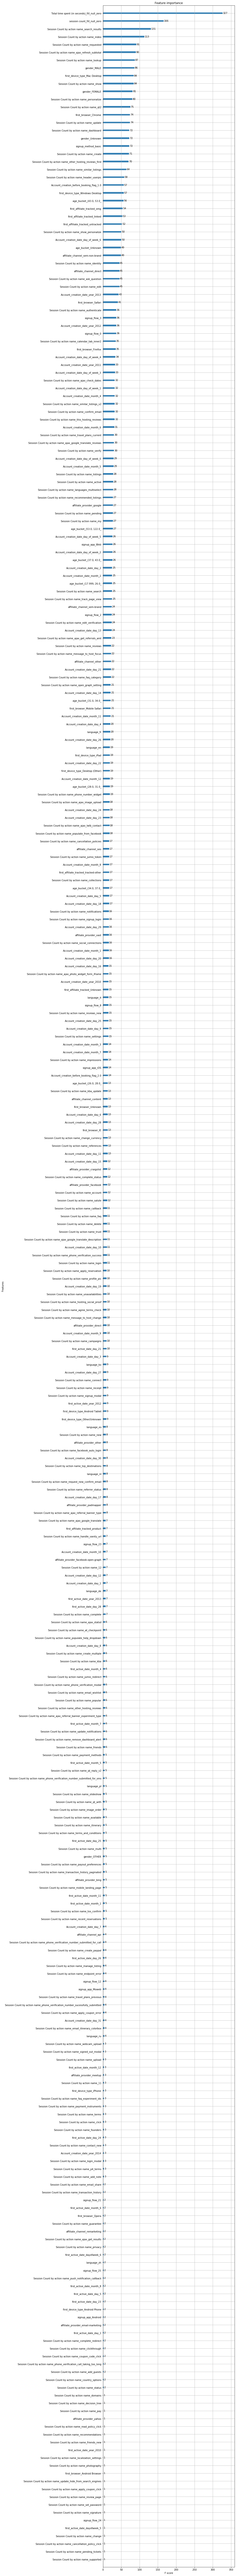

In [54]:
xgb.plot_importance(model_xgboost)
plt.rcParams['figure.figsize']=[10,15]
plt.show()

After trying out random forest, logistic regression and xgboost, I've decided to use xgboost since it's given me the best result. The next step for the project would be to leverage randomized search and grid search for hyperparameter tuning for the xgboost. Since tuning on the parameters and increasing the number of estimators would be quite expensive, I'm not going to try it for now.

# Export the training data set sample file into csv:

In [62]:
X_train.head().to_csv("C:/Users/yuka.abe/Desktop/Airbnb Kaggle DataSet/user_training_dataset_sample_for_multi_class_classification.csv")

# Import the user_id with "NDF" as the first destination country

In [155]:
NDF_Country_prediction=pd.read_csv("C:/Users/yuka.abe/Desktop/Airbnb Kaggle DataSet/kaggle_testing_data_prediction_with_NDF_destination.csv")

In [156]:
NDF_Country_prediction.head()

,Unnamed: 0,id,Prediction
0,0,5uwns89zht,False
1,1,jtl0dijy2j,True
2,2,xx0ulgorjt,True
3,3,6c6puo6ix0,True
4,4,czqhjk3yfe,True


In [157]:
del NDF_Country_prediction['Unnamed: 0']
NDF_Country_prediction.set_index('id', inplace=True)

# Import the kaggle testing dataset:

In [98]:
X_TEST_multiclass=pd.read_csv("C:/Users/yuka.abe/Desktop/Airbnb Kaggle DataSet/testing_dataset_for_multiclass_classification.csv")

In [158]:
X_TEST_multiclass.head()

,Total time spent (in seconds)_fill_null_zero,session count_fill_null_zero,Session Count by action name_10,Session Count by action name_11,Session Count by action name_12,Session Count by action name_15,Session Count by action name_about_us,Session Count by action name_accept_decline,Session Count by action name_account,Session Count by action name_acculynk_bin_check_failed,...,first_active_date_dayofweek_6,"age_bucket_(17.999, 26.0_","age_bucket_(26.0, 28.0_","age_bucket_(28.0, 31.0_","age_bucket_(31.0, 34.0_","age_bucket_(34.0, 37.0_","age_bucket_(37.0, 43.0_","age_bucket_(43.0, 53.0_","age_bucket_(53.0, 122.0_",age_bucket_Unknown
id,,,,,,,,,,,,,,,,,,,,,
5uwns89zht,119187.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
jtl0dijy2j,250119.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
xx0ulgorjt,975575.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
6c6puo6ix0,123001.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
czqhjk3yfe,454023.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1


In [102]:
X_TEST_multiclass.set_index('id', inplace=True)

In [110]:
X_TEST_multiclass=X_TEST_multiclass[X_train.columns]

In [114]:
xg_boost_multi_class_prediction=model_xgboost.predict(X_TEST_multiclass)

In [120]:
multiclass_classification_top_five_countries=multinary_classification_model_predict_probability_by_class(model_xgboost, X_TEST_multiclass)
    

In [125]:
multiclass_classification_top_five_countries.set_index('id', inplace=True)

# Seperate the data into the users with "NDF" as the first destination country and the users with the actual countries as the first destination:

In [159]:
multiclass_classification_top_five_countries_1=pd.merge(multiclass_classification_top_five_countries,NDF_Country_prediction, left_index=True, right_index=True)

In [161]:
multiclass_classification_top_five_countries_non_NDF=multiclass_classification_top_five_countries_1.loc[multiclass_classification_top_five_countries_1['Prediction']==True, ['variable', 'Probability']]
multiclass_classification_top_five_countries_NDF=multiclass_classification_top_five_countries_1.loc[multiclass_classification_top_five_countries_1['Prediction']==False, ['variable', 'Probability']]

In [171]:
multiclass_classification_top_five_countries_NDF_top4=multiclass_classification_top_five_countries_NDF.groupby('id').head(4)

In [189]:
multiclass_classification_top_five_countries_NDF_top1=pd.DataFrame({'id': list(multiclass_classification_top_five_countries_NDF_top4.index.unique()), 'variable': 'NDF','Probability':1})
multiclass_classification_top_five_countries_NDF_top1.set_index('id', inplace=True)

In [195]:
multiclass_classification_top_five_countries_NDF_top5=pd.concat([multiclass_classification_top_five_countries_NDF_top1, multiclass_classification_top_five_countries_NDF_top4])

In [ ]:
df_prob_melt.sort_values(by=['id', 'Probability'], ascending=[True, False], inplace=True)
df_prob_melt_top5_countries=df_prob_melt.groupby('id').head(4)

In [197]:
multiclass_classification_top_five_countries_NDF_top5.sort_values(by=['id', 'Probability'], ascending=[True, False], inplace=True)

In [198]:
multiclass_classification_top_five_countries_NDF_top5=multiclass_classification_top_five_countries_NDF_top5.groupby('id').head(5)

In [202]:
multiclass_classification_top_five_countries_NDF_top5=pd.DataFrame(multiclass_classification_top_five_countries_NDF_top5['variable'])
multiclass_classification_top_five_countries_non_NDF=pd.DataFrame(multiclass_classification_top_five_countries_non_NDF['variable'])

In [203]:
multiclass_classification_top_five_countries_submission=pd.concat([multiclass_classification_top_five_countries_NDF_top5,multiclass_classification_top_five_countries_non_NDF ])

In [205]:
multiclass_classification_top_five_countries_submission.to_csv("C:/Users/yuka.abe/Desktop/Airbnb Kaggle DataSet/Kaggle_testing_set_prediction_submission_file.csv")